# Carga de datos

In [1]:
import numpy as np
import pandas as pd

def cargar_datos_npz(ruta_archivo):
    """
    Carga un archivo .npz con datos de simulación y reales.
    
    Retorna:
    - df_modelo: DataFrame con columnas ['fecha', 'simulado']
    - df_reales: DataFrame con columnas ['fecha', 'real']
    """
    data = np.load(ruta_archivo, allow_pickle=True)
    
    fechas_modelo = pd.to_datetime(data['fechas_modelo'])
    simulados = data['simulados']
    
    fechas_reales = pd.to_datetime(data['fechas_reales'])
    reales = data['reales']
    
    df_modelo = pd.DataFrame({
        'fecha': fechas_modelo,
        'real': simulados
    })
    
    df_reales = pd.DataFrame({
        'fecha': fechas_reales,
        'real': reales
    })
    
    return df_modelo, df_reales


In [2]:
# Para entrenamiento de Italia
df_modelo_it, df_reales_it = cargar_datos_npz('sir_italy_train.npz')

# Para test de Italia
df_modelo_it_test, df_reales_it_test = cargar_datos_npz('sir_italy_test.npz')

# Para entrenamiento de España
df_modelo_es, df_reales_es = cargar_datos_npz('sir_spain_train.npz')

# Para test de España
df_modelo_es_test, df_reales_es_test = cargar_datos_npz('sir_spain_test.npz')

# Para entrenamiento de Colombia
df_modelo_col, df_reales_col = cargar_datos_npz('sir_colombia_train.npz')

# Para test de Colombia
df_modelo_col_test, df_reales_col_test = cargar_datos_npz('sir_colombia_test.npz')



# Forward Neural Network

In [96]:
import torch
import torch.nn as nn

class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.net(x)

def entrenar_fnn(X_train, y_train, lr=0.01, epochs=5000):
    """
    Entrena una red FNN para ajustar los datos (X_train, y_train).
    """
    model = FNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    return model

def preparar_datos_fnn(df_train, df_test):
    """
    Prepara los tensores X_train, y_train, X_test a partir de los DataFrames con columnas 'fecha' y 'real'.
    """
    # Convertir fechas a días desde el inicio
    dias_train = (df_train['fecha'] - df_train['fecha'].iloc[0]).dt.days.values.reshape(-1, 1)
    dias_test = (df_test['fecha'] - df_train['fecha'].iloc[0]).dt.days.values.reshape(-1, 1)

    X_train = torch.tensor(dias_train, dtype=torch.float32)
    y_train = torch.tensor(df_train['real'].values.reshape(-1, 1), dtype=torch.float32)
    X_test = torch.tensor(dias_test, dtype=torch.float32)

    return X_train, y_train, X_test

import matplotlib.pyplot as plt

def graficar_fnn(model, df_train, df_test, X_train, X_test, df_real_train, df_real_test, label_pais='Italia'):
    """
    Grafica el ajuste de la red FNN en entrenamiento y su predicción en test.
    """
    from matplotlib import rc
    rc('font', **{'serif': ['Computer Modern']})
    rc('text', usetex=True)
    rc('legend', fontsize=15)
    rc('xtick', labelsize=15)
    rc('ytick', labelsize=15)
    
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train).numpy().flatten()
        y_pred_test = model(X_test).numpy().flatten()

    # Gráfico de entrenamiento
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_real_train['fecha'], df_real_train['real'], 'o', label='Datos reales ('+label_pais+')', color='salmon', markersize = 4)
    ax.plot(df_train['fecha'], y_pred_train, '--', label='Predicción FNN (train)', color='olive', linewidth=3)
    ax.set_xlabel("Fecha", fontsize=20)
    ax.set_ylabel("Fracción de infectados", fontsize=20)
    ax.tick_params(axis='x', labelrotation=45)
    ax.legend()
    plt.savefig('figures/FNN_train_'+label_pais+'.pdf')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    # Gráfico de test
    ax.plot(df_real_test['fecha'], df_real_test['real'], 'o', label='Datos reales ('+label_pais+')', color='salmon', markersize = 4)
    ax.plot(df_test['fecha'], y_pred_test, '--', label='Predicción FNN (test)', color='olive', linewidth=3)
    ax.set_xlabel("Fecha", fontsize=20)
    ax.set_ylabel("Fracción de infectados", fontsize=20)
    if (label_pais == 'Italia'):
        ax.set_ylim([0, 0.1])
    elif (label_pais == 'España'):
        ax.set_ylim([0.1,0.35])
    elif (label_pais == 'Colombia'):
        ax.set_ylim([0.0,0.3])
    ax.tick_params(axis='x', labelrotation=45)
    ax.legend()
    plt.savefig('figures/FNN_test_'+label_pais+'.pdf')
    plt.show()



In [46]:
X_train_it, y_train_it, X_test_it = preparar_datos_fnn(df_modelo_it, df_modelo_it_test)
model_it = entrenar_fnn(X_train_it, y_train_it, lr=0.01, epochs=7000)


Epoch 0, Loss: 0.283378
Epoch 500, Loss: 0.010403
Epoch 1000, Loss: 0.000051
Epoch 1500, Loss: 0.000021
Epoch 2000, Loss: 0.000018
Epoch 2500, Loss: 0.000019
Epoch 3000, Loss: 0.000018
Epoch 3500, Loss: 0.000018
Epoch 4000, Loss: 0.000019
Epoch 4500, Loss: 0.000063
Epoch 5000, Loss: 0.000022
Epoch 5500, Loss: 0.000021
Epoch 6000, Loss: 0.000016
Epoch 6500, Loss: 0.000019


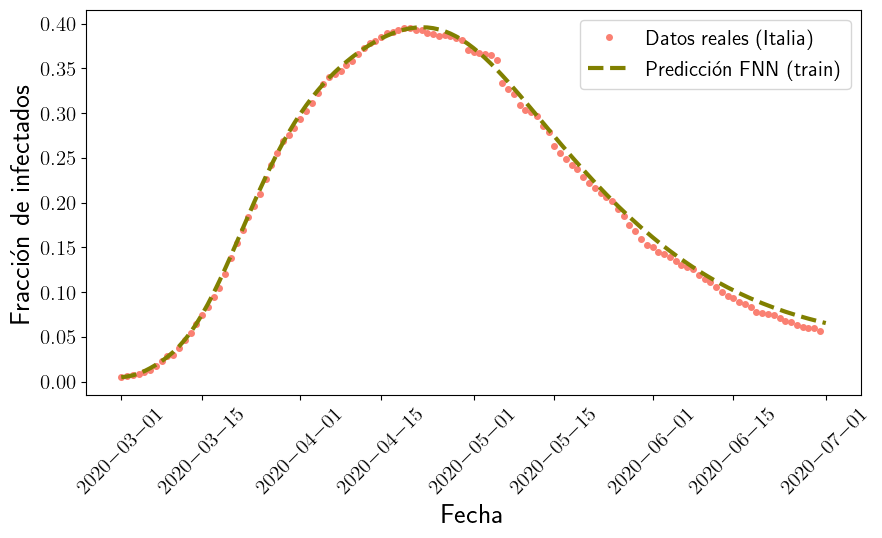

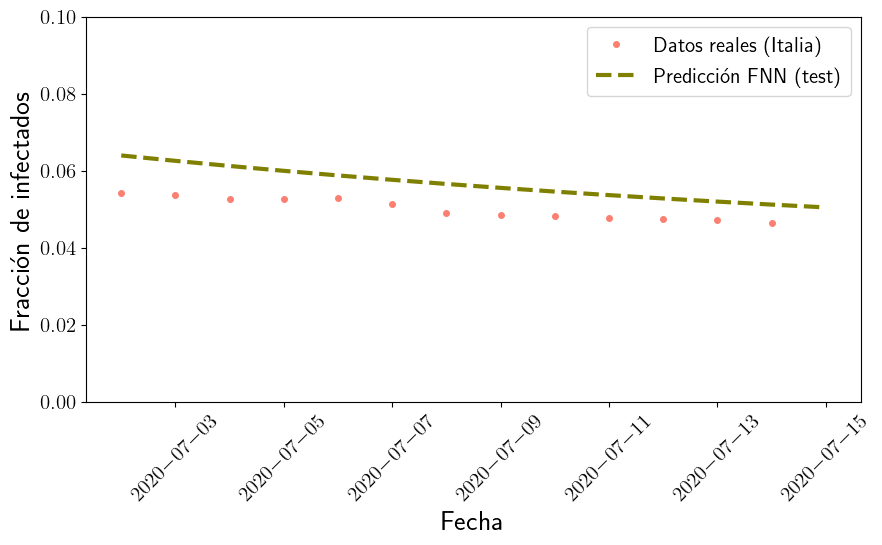

In [47]:

graficar_fnn(model_it, df_modelo_it, df_modelo_it_test, X_train_it, X_test_it, df_reales_it, df_reales_it_test, label_pais='Italia')


In [50]:
X_train_es, y_train_es, X_test_es = preparar_datos_fnn(df_modelo_es, df_modelo_es_test)
model_es = entrenar_fnn(X_train_es, y_train_es, lr=0.01, epochs=8000)

Epoch 0, Loss: 0.035071
Epoch 500, Loss: 0.000478
Epoch 1000, Loss: 0.000263
Epoch 1500, Loss: 0.000052
Epoch 2000, Loss: 0.000045
Epoch 2500, Loss: 0.000040
Epoch 3000, Loss: 0.000034
Epoch 3500, Loss: 0.000028
Epoch 4000, Loss: 0.000024
Epoch 4500, Loss: 0.000023
Epoch 5000, Loss: 0.000023
Epoch 5500, Loss: 0.000034
Epoch 6000, Loss: 0.000023
Epoch 6500, Loss: 0.000022
Epoch 7000, Loss: 0.000026
Epoch 7500, Loss: 0.000029


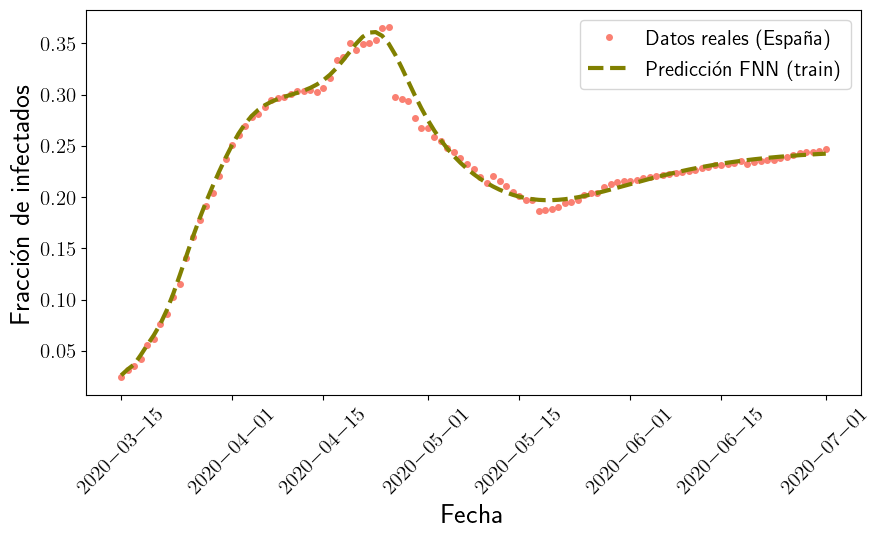

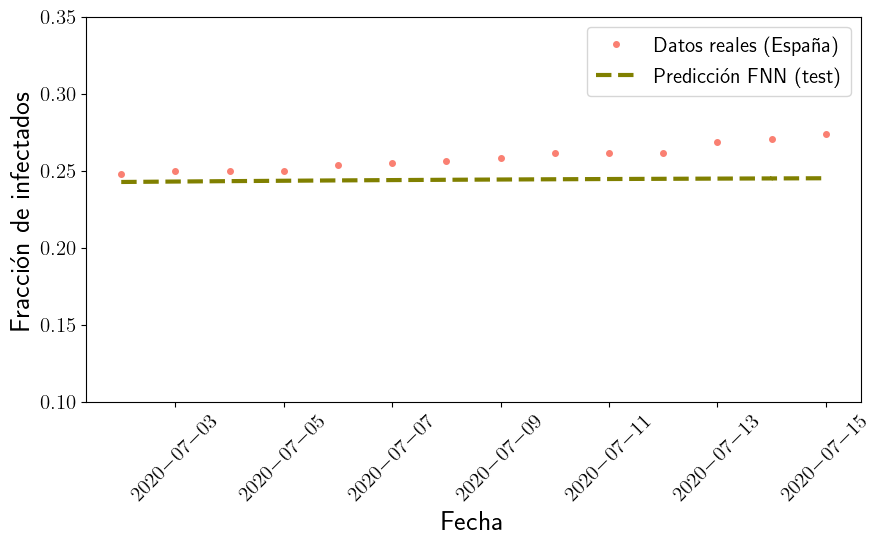

In [51]:
graficar_fnn(model_es, df_modelo_es, df_modelo_es_test, X_train_es, X_test_es, df_reales_es, df_reales_es_test, label_pais='España')

In [101]:
X_train_col, y_train_col, X_test_col = preparar_datos_fnn(df_reales_col, df_reales_col_test)
model_col = entrenar_fnn(X_train, y_train, lr=0.01, epochs=8000)

Epoch 0, Loss: 0.353163
Epoch 500, Loss: 0.000753
Epoch 1000, Loss: 0.000747
Epoch 1500, Loss: 0.000745
Epoch 2000, Loss: 0.000744
Epoch 2500, Loss: 0.000055
Epoch 3000, Loss: 0.000054
Epoch 3500, Loss: 0.000056
Epoch 4000, Loss: 0.000056
Epoch 4500, Loss: 0.000053
Epoch 5000, Loss: 0.000051
Epoch 5500, Loss: 0.000050
Epoch 6000, Loss: 0.000050
Epoch 6500, Loss: 0.000055
Epoch 7000, Loss: 0.000050
Epoch 7500, Loss: 0.000068


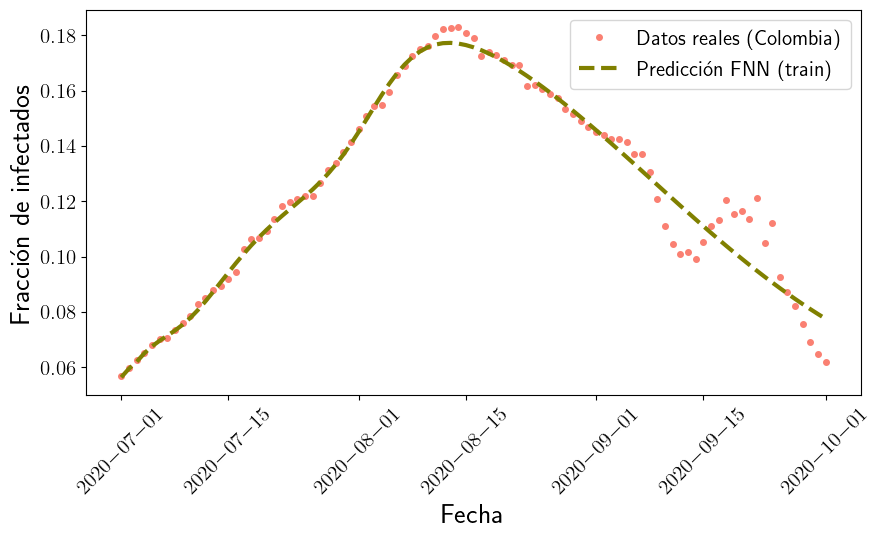

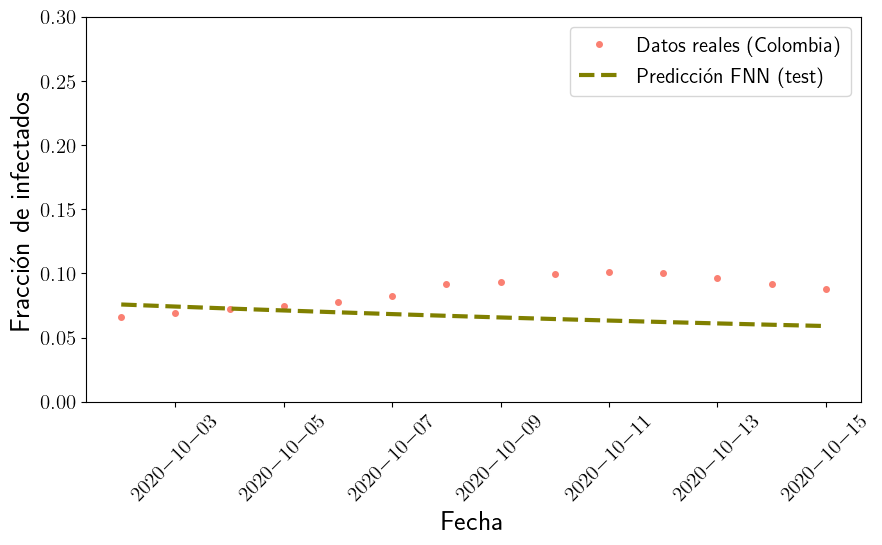

In [102]:
graficar_fnn(model_col, df_reales_col, df_reales_col_test, X_train_col, X_test_col, df_reales_col, df_reales_col_test, label_pais='Colombia')

# NAR Neural Network

In [92]:
import torch
import torch.nn as nn
import pandas as pd

class NAR(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.net(x)
    
def preparar_datos_nar(df, d):
    """
    Prepara los pares (input, target) para una red NAR de ventana d.
    Entrada:
        df: DataFrame con columna 'real'
        d: número de días anteriores usados como input

    Retorna:
        X (N-d, d): tensor de entradas
        y (N-d, 1): tensor de salidas
        fechas: fechas correspondientes a cada y[n] (para graficar luego)
    """
    valores = df['real'].values.astype('float32')
    X = []
    y = []
    fechas = []

    for t in range(d, len(valores)):
        X.append(valores[t - d:t])
        y.append(valores[t])
        fechas.append(df['fecha'].iloc[t])

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

    return X_tensor, y_tensor, fechas

def entrenar_nar(X_train, y_train, d, lr=0.01, epochs=5000):
    model = NAR(d)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    return model


import matplotlib.pyplot as plt

def graficar_nar(model, X_train, y_train, fechas, df_test, df_real_train, df_real_test ,d, label_pais='País'):
    """
    Grafica la predicción en entrenamiento y test para una NAR.
    """
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train).numpy().flatten()

    # Gráfico de entrenamiento
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_real_train['fecha'], df_real_train['real'], 'o', label='Datos reales ('+label_pais+')', color='salmon', markersize = 4)
    ax.plot(fechas, y_pred_train, '--', label='Predicción NAR (train)', color='olive', linewidth = 3)
    ax.set_xlabel("Fecha", fontsize=20)
    ax.set_ylabel("Fracción de infectados", fontsize=20)
    ax.tick_params(axis='x', labelrotation=45)    
    ax.text(0.1, 0.8, 'd = '+str(d)+' días', transform=ax.transAxes, fontsize=20)
    ax.legend()
    plt.savefig('figures/NAR_train_'+label_pais+'.pdf')
    plt.show()

    # --- Test: predicción autoregresiva paso a paso ---
    test_values = list(df_test['real'].values[:d].astype('float32'))  # semillas
    predicciones = []

    model.eval()
    with torch.no_grad():
        for i in range(d, len(df_test)):
            input_seq = torch.tensor(test_values[-d:], dtype=torch.float32).reshape(1, -1)
            next_val = model(input_seq).item()
            predicciones.append(next_val)
            test_values.append(next_val)  # usar la predicción como input futuro

    # Fechas de test alineadas
    fechas_test = df_test['fecha'].iloc[d:].reset_index(drop=True)
    reales_test = df_test['real'].iloc[d:].reset_index(drop=True)

    # Gráfico de test
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_real_test['fecha'], df_real_test['real'], 'o', label='Datos reales ('+label_pais+')', color='salmon', markersize = 4)
    plt.plot(fechas_test, predicciones, '--', label='Predicción NAR (test)', color='olive', linewidth = 3)
    ax.set_xlabel("Fecha", fontsize=20)
    ax.set_ylabel("Fracción de infectados", fontsize=20)
    ax.tick_params(axis='x', labelrotation=45)   
    if (label_pais == 'Italia'):
        ax.set_ylim([-0.02, 0.13])
        ax.set_xlim([pd.to_datetime('2020-07-02'),pd.to_datetime('2020-07-15')])
    elif (label_pais == 'España'):
        ax.set_ylim([0.15,0.55])
        ax.set_xlim([pd.to_datetime('2020-07-02'),pd.to_datetime('2020-07-15')])
    elif (label_pais == 'Colombia'):
        ax.set_ylim([0.0,0.3])
        ax.set_xlim([pd.to_datetime('2020-10-02'),pd.to_datetime('2020-10-15')])
    ax.legend()
    plt.savefig('figures/NAR_test_'+label_pais+'.pdf')
    plt.show()


In [73]:
d_it = 7  # tamaño de la ventana

X_train_nar_it, y_train_nar_it, fechas_nar_it = preparar_datos_nar(df_modelo_it, d_it)
model_nar_it = entrenar_nar(X_train_nar_it, y_train_nar_it, d_it)

Epoch 0, Loss: 0.073879
Epoch 500, Loss: 0.000045
Epoch 1000, Loss: 0.000017
Epoch 1500, Loss: 0.000003
Epoch 2000, Loss: 0.000001
Epoch 2500, Loss: 0.000001
Epoch 3000, Loss: 0.000001
Epoch 3500, Loss: 0.000001
Epoch 4000, Loss: 0.000001
Epoch 4500, Loss: 0.000001


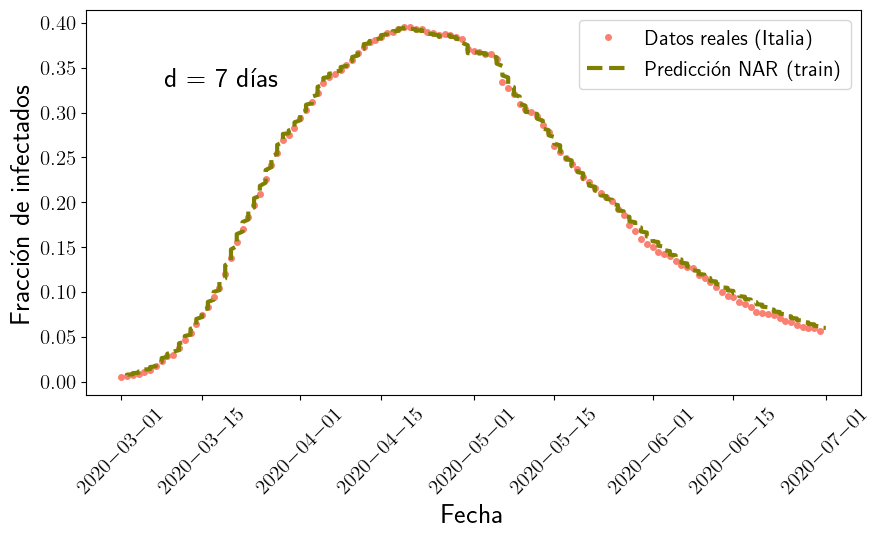

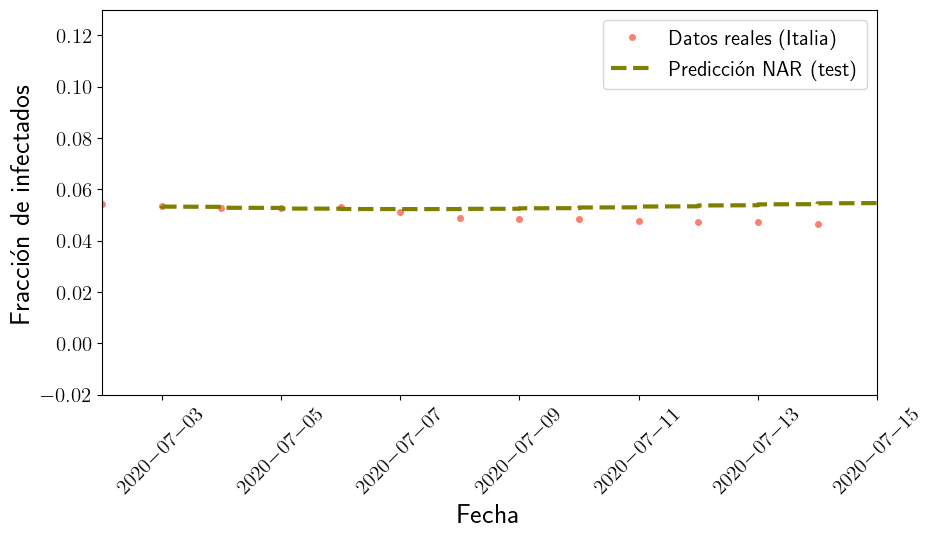

In [79]:
graficar_nar(model_nar_it, X_train_nar_it, y_train_nar_it, fechas_nar_it, df_modelo_it_test, df_reales_it, df_reales_it_test, d_it, label_pais='Italia')

In [90]:
d_es = 7  # tamaño de la ventana

X_train_nar_es, y_train_nar_es, fechas_nar_es = preparar_datos_nar(df_modelo_es, d_es)
model_nar_es = entrenar_nar(X_train_nar_es, y_train_nar_es, d_es)

Epoch 0, Loss: 0.039969
Epoch 500, Loss: 0.000025
Epoch 1000, Loss: 0.000009
Epoch 1500, Loss: 0.000002
Epoch 2000, Loss: 0.000002
Epoch 2500, Loss: 0.000002
Epoch 3000, Loss: 0.000002
Epoch 3500, Loss: 0.000010
Epoch 4000, Loss: 0.000002
Epoch 4500, Loss: 0.000002


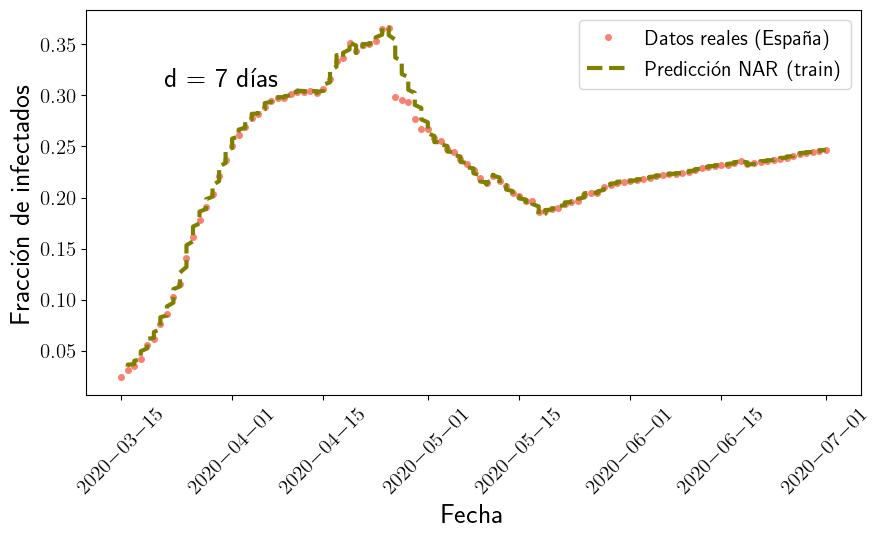

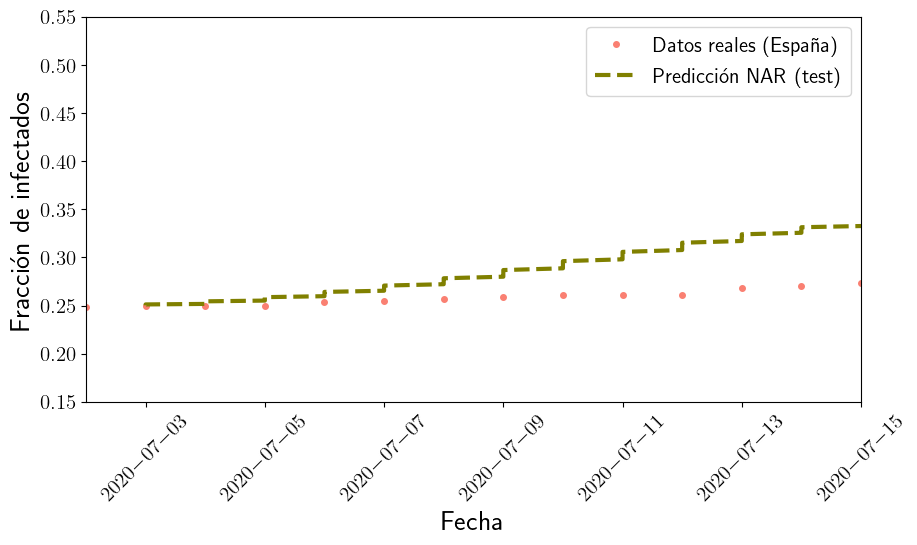

In [93]:
graficar_nar(model_nar_es, X_train_nar_es, y_train_nar_es, fechas_nar_es, df_modelo_es_test, df_reales_es, df_reales_es_test, d_es, label_pais='España')

In [94]:
d_col = 5  # tamaño de la ventana

X_train_nar_col, y_train_nar_col, fechas_nar_col = preparar_datos_nar(df_modelo_col, d_col)
model_nar_col = entrenar_nar(X_train_nar_col, y_train_nar_col, d_col)


Epoch 0, Loss: 0.077150
Epoch 500, Loss: 0.000004
Epoch 1000, Loss: 0.000003
Epoch 1500, Loss: 0.000003
Epoch 2000, Loss: 0.000002
Epoch 2500, Loss: 0.000002
Epoch 3000, Loss: 0.000001
Epoch 3500, Loss: 0.000001
Epoch 4000, Loss: 0.000001
Epoch 4500, Loss: 0.000001


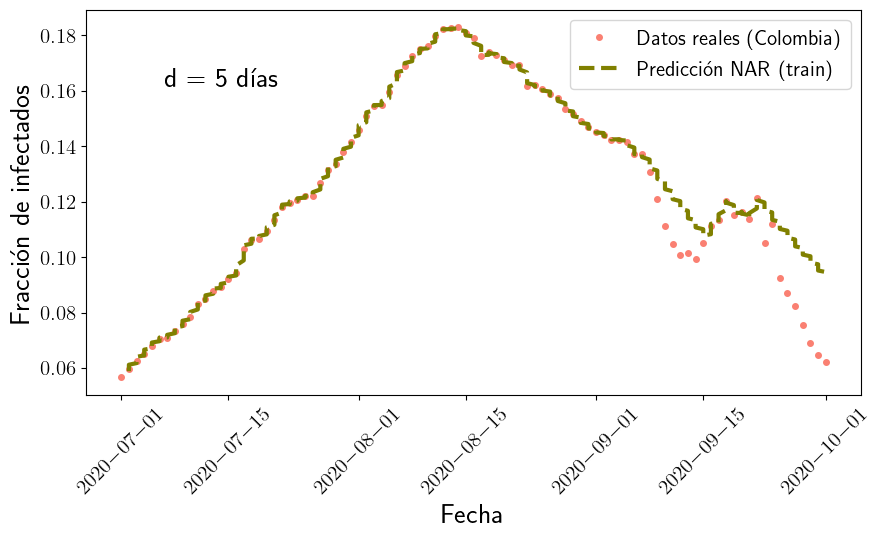

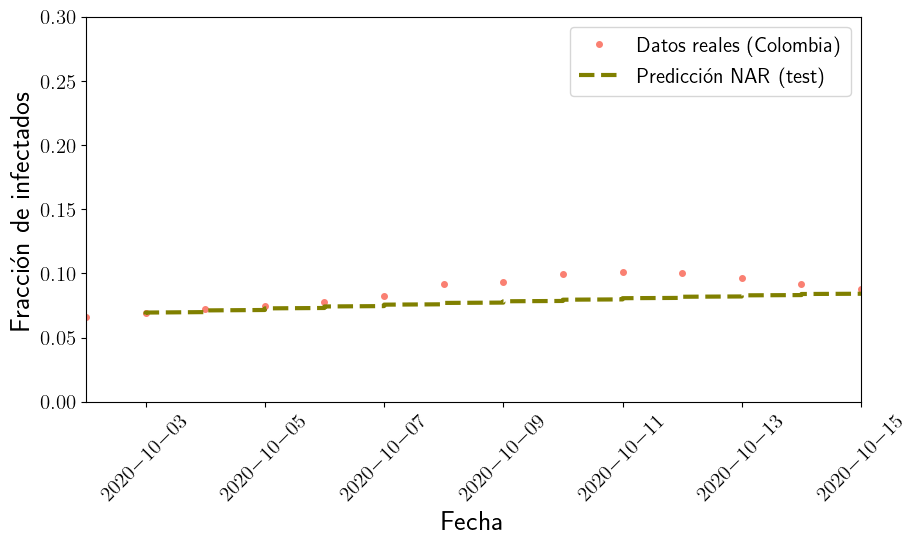

In [95]:
graficar_nar(model_nar_col, X_train_nar_col, y_train_nar_col, fechas_nar_col, df_modelo_col_test, df_reales_col, df_reales_col_test, d_col, label_pais='Colombia')